In [1]:
import os
import torch
import numpy as np

device = torch.device('cuda')

In [2]:
from minimodel import data
mouse_id = 5

data_path = './data'
weight_path = './checkpoints_trained'
np.random.seed(1)

In [3]:
# load images
img = data.load_images(data_path, mouse_id, file=data.img_file_name[mouse_id])

raw image shape:  (68000, 66, 264)
cropped image shape:  (68000, 66, 130)
img:  (68000, 66, 130) -2.0829253 2.1060908 float32


In [4]:
# load neurons
fname = '%s_nat60k_%s.npz'%(data.db[mouse_id]['mname'], data.db[mouse_id]['datexp'])
spks, istim_train, istim_test, xpos, ypos, spks_rep_all = data.load_neurons(file_path = os.path.join(data_path, fname), mouse_id = mouse_id)
n_stim, n_neurons = spks.shape


loading activities from ./data/FX20_nat60k_2023_09_29.npz


In [5]:
# split train and validation set
itrain, ival = data.split_train_val(istim_train, train_frac=0.9)


splitting training and validation set...
itrain:  (43081,)
ival:  (4787,)


In [6]:
spks, spks_rep_all = data.normalize_spks(spks, spks_rep_all, itrain)


normalizing neural data...
finished


In [7]:
from minimodel import metrics
ineuron = 0
test_fev = 0.0
for i in range(1000):
    ineuron = i
    ineur = [ineuron]
    spks_rep = []
    for i in range(len(spks_rep_all)):
        spks_rep.append(spks_rep_all[i][:,ineur])
    test_fev = metrics.fev(spks_rep)

    if test_fev >= 0.15: break

print(f"ineuron: {ineuron}, test_fev: {test_fev}")

ineur = [ineuron]
spks_train = torch.from_numpy(spks[itrain][:,ineur]).to(device)
spks_val = torch.from_numpy(spks[ival][:,ineur]).to(device)
print('spks_train: ', spks_train.shape, spks_train.min(), spks_train.max())
print('spks_val: ', spks_val.shape, spks_val.min(), spks_val.max())

img_train = torch.from_numpy(img[istim_train][itrain]).to(device).unsqueeze(1) # change :130 to 25:100 
img_val = torch.from_numpy(img[istim_train][ival]).to(device).unsqueeze(1)
img_test = torch.from_numpy(img[istim_test]).to(device).unsqueeze(1)

print('img_train: ', img_train.shape, img_train.min(), img_train.max())
print('img_val: ', img_val.shape, img_val.min(), img_val.max())
print('img_test: ', img_test.shape, img_test.min(), img_test.max())

input_Ly, input_Lx = img_train.shape[-2:]

ineuron: 12, test_fev: [0.17706311]
spks_train:  torch.Size([43081, 1]) tensor(-1.2562e-16, device='cuda:0') tensor(15.5218, device='cuda:0')
spks_val:  torch.Size([4787, 1]) tensor(0., device='cuda:0') tensor(13.7926, device='cuda:0')
img_train:  torch.Size([43081, 1, 66, 130]) tensor(-2.0829, device='cuda:0') tensor(2.1061, device='cuda:0')
img_val:  torch.Size([4787, 1, 66, 130]) tensor(-2.0829, device='cuda:0') tensor(2.1061, device='cuda:0')
img_test:  torch.Size([500, 1, 66, 130]) tensor(-2.0829, device='cuda:0') tensor(2.1061, device='cuda:0')


In [8]:
# build model
from minimodel import model_builder
nlayers = 2
nconv1 = 16
nconv2 = 64
seed = 1
hs_readout = 0.03
wc_coef = 0.2
model, in_channels = model_builder.build_model(NN=1, n_layers=nlayers, n_conv=nconv1, n_conv_mid=nconv2, Wc_coef=wc_coef)
model_name = model_builder.create_model_name(data.mouse_names[mouse_id], data.exp_date[mouse_id], ineuron=ineur[0], n_layers=nlayers, in_channels=in_channels, seed=seed,hs_readout=hs_readout)

model_path = os.path.join(weight_path, model_name)
model = model.to(device)

core shape:  torch.Size([1, 64, 33, 65])
input shape of readout:  (64, 33, 65)
model name:  FX20_092923_2layer_16_64_clamp_norm_depthsep_pool_nn12_hs3e-02_xrange_176.pt


In [9]:
# train model
from minimodel import model_trainer
if not os.path.exists(model_path):
    if mouse_id == 5: pretrained_model_path = os.path.join(weight_path, f'{data.mouse_names[mouse_id]}_{data.exp_date[mouse_id]}_2layer_16_320_clamp_norm_depthsep_pool_xrange_176.pt')
    else: pretrained_model_path = os.path.join(weight_path, f'{data.mouse_names[mouse_id]}_{data.exp_date[mouse_id]}_2layer_16_320_clamp_norm_depthsep_pool.pt')
    print('pretrained_model_path: ', pretrained_model_path)
    pretrained_state_dict = torch.load(pretrained_model_path, map_location=device)
    # initialize conv1 with the fullmodel weights
    model.core.features.layer0.conv.weight.data = pretrained_state_dict['core.features.layer0.conv.weight']
    model.core.features.layer0.conv.weight.requires_grad = False
    best_state_dict = model_trainer.train(model, spks_train, spks_val, img_train, img_val, device=device, l2_readout=0.2, hs_readout=hs_readout)
    torch.save(best_state_dict, model_path)
    print('saved model', model_path)
model.load_state_dict(torch.load(model_path))
print('loaded model', model_path)

pretrained_model_path:  ./checkpoints_trained/FX20_092923_2layer_16_320_clamp_norm_depthsep_pool_xrange_176.pt
Learning rate = 0.001
epoch 0, train_loss = 0.6905, val_loss = 0.6213, varexp_val = 0.1552, time 10.06s
epoch 1, train_loss = 0.6337, val_loss = 0.6103, varexp_val = 0.1838, time 15.17s
epoch 2, train_loss = 0.6298, val_loss = 0.6108, varexp_val = 0.1875, time 20.27s
epoch 3, train_loss = 0.6278, val_loss = 0.6143, varexp_val = 0.1875, time 25.37s
epoch 4, train_loss = 0.6247, val_loss = 0.6070, varexp_val = 0.1883, time 30.47s
epoch 5, train_loss = 0.6230, val_loss = 0.6044, varexp_val = 0.1968, time 35.57s
epoch 6, train_loss = 0.6225, val_loss = 0.6037, varexp_val = 0.1958, time 40.67s
epoch 7, train_loss = 0.6200, val_loss = 0.6102, varexp_val = 0.1895, time 45.77s
epoch 8, train_loss = 0.6199, val_loss = 0.6141, varexp_val = 0.1750, time 50.87s
epoch 9, train_loss = 0.6189, val_loss = 0.6054, varexp_val = 0.1947, time 55.98s
epoch 10, train_loss = 0.6171, val_loss = 0.613

In [10]:
# test model
test_pred = model_trainer.test_epoch(model, img_test)
print('test_pred: ', test_pred.shape, test_pred.min(), test_pred.max())

test_pred:  (500, 1) 0.09825486 2.860871


In [11]:
from minimodel import metrics
spks_rep = []
for i in range(len(spks_rep_all)):
    spks_rep.append(spks_rep_all[i][:,ineur])
test_fev, test_feve = metrics.feve(spks_rep, test_pred)

print('FEV (test): ', np.mean(test_fev))
print('FEVE (test): ', np.mean(test_feve))

FEV (test):  0.17706311
FEVE (test):  0.7015559


# check Wc

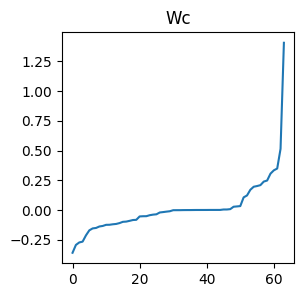

In [12]:
Wc = model.readout.Wc.detach().cpu().numpy().squeeze()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.plot(np.sort(Wc))
ax.set_title('Wc')
plt.show()

# check fullmodel performance

In [13]:
from minimodel import model_builder
nlayers = 2
nconv1 = 16
nconv2 = 320
fullmodel, in_channels = model_builder.build_model(NN=n_neurons, n_layers=nlayers, n_conv=nconv1, n_conv_mid=nconv2)
model_name = model_builder.create_model_name(data.mouse_names[mouse_id], data.exp_date[mouse_id], n_layers=nlayers, in_channels=in_channels)
model_path = os.path.join(weight_path, model_name)

fullmodel.load_state_dict(torch.load(model_path))
print('loaded model', model_path)
fullmodel = fullmodel.to(device)

core shape:  torch.Size([1, 320, 33, 65])
input shape of readout:  (320, 33, 65)
model name:  FX20_092923_2layer_16_320_clamp_norm_depthsep_pool_xrange_176.pt
loaded model ./checkpoints_trained/FX20_092923_2layer_16_320_clamp_norm_depthsep_pool_xrange_176.pt


In [14]:
test_pred = model_trainer.test_epoch(fullmodel, img_test)
print('test_pred: ', test_pred.shape, test_pred.min(), test_pred.max())

test_pred:  (500, 2746) 0.001676619 9.360834


In [15]:
from minimodel import metrics
test_fev, test_feve = metrics.feve(spks_rep, test_pred[:, ineur])
print('FEVE (test): ', np.mean(test_feve))

FEVE (test):  0.79947907


# calculate category variance (FECV)

In [16]:
# load txt16 data
fname = 'text16_%s_%s.npz'%(data.db[mouse_id]['mname'], data.db[mouse_id]['datexp'])
dat = np.load(os.path.join(data_path, fname), allow_pickle=True)
txt16_spks_test = dat['ss_all']
nstim, nrep, nneuron = txt16_spks_test.shape
txt16_istim_test = dat['ss_istim'].astype(int)
txt16_istim_test = np.repeat(txt16_istim_test[:, np.newaxis], nrep, axis=1).flatten()
txt16_labels_test = dat['ss_labels']
txt16_labels_test = np.repeat(txt16_labels_test[:, np.newaxis], nrep, axis=1).flatten()

print('txt16_labels_test shape:', txt16_labels_test.shape)

txt16_istim_train = dat['istim'].astype(int)
txt16_labels_train = dat['labels']

print('txt16_labels_train shape:', txt16_labels_train.shape)

txt16_labels = np.hstack((txt16_labels_train, txt16_labels_test))
txt16_istim = np.hstack((txt16_istim_train, txt16_istim_test))

FileNotFoundError: [Errno 2] No such file or directory: './data/text16_FX20_2023_09_29.npz'

In [ ]:
# load txt16 images
img = data.load_images(data_path, mouse_id, file='nat60k_text16.mat', normalize=False)
txt16_img = img[txt16_istim]
# zscore txt16_imgs
img_mean = txt16_img.mean()
img_std = txt16_img.std()
txt16_img_zscore = (txt16_img - img_mean) / img_std
txt16_img_zscore = torch.from_numpy(txt16_img_zscore).to(device).unsqueeze(1)
print(txt16_img_zscore.shape)

In [ ]:
txt16_pred = model_trainer.test_epoch(model, txt16_img_zscore)
print('test pred:', txt16_pred.shape)

In [ ]:
catvar = metrics.fecv_pairwise(txt16_pred.T, txt16_labels)
print(f'FECV (neuron {ineur[0]}): {catvar[0]:.4f}')

# visualize neuron

In [ ]:
# find the unique train images
Nimgs_unique = img_train.shape[0]

# get conv2 features of train images (in batches)
model.eval()
batch_size = 160
nconv2 = 64
conv2_fvs = np.zeros((Nimgs_unique, nconv2))
for i in range(0, Nimgs_unique, batch_size):
    images = img_train[i:i+batch_size].to(device)
    conv2_fv = model.core(images)
    wxy_fv = torch.einsum('iry, irx, ncyx -> ncr', model.readout.Wy, model.readout.Wx, conv2_fv).detach().cpu().numpy().squeeze()
    conv2_fvs[i:i+batch_size] = wxy_fv

# sort the features and select top 8 image for each channel
fv_isort = np.argsort(-conv2_fvs, axis=0)
Wc = model.readout.Wc.detach().cpu().numpy().squeeze()
ivalid_Wc = np.where(np.abs(Wc)>0.01)[0]
print('ivalid_Wc:', len(ivalid_Wc))
fv_isort = fv_isort[:, ivalid_Wc]
fv_isort_top8 = fv_isort[:8]
Nimg, Nchannel = fv_isort_top8.shape

# get mask of the images
from minimodel.utils import get_image_mask
ineuron_mask_up = get_image_mask(model, Ly=input_Ly, Lx=input_Lx)

# get predictions from the training set
neuron_activity_model = model_trainer.test_epoch(model, img_train)
neuron_activity_model = neuron_activity_model.squeeze()
prediction_isort = np.argsort(neuron_activity_model)[::-1]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from minimodel.utils import add_channel_frame

# Parameters for the second plot
pad = 5
vmin = 0
vmax = 255
valid_wc = Wc[ivalid_Wc]
isort = np.argsort(valid_wc)[::-1]
Nchannel = 8
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
# Combined plot layout
fig = plt.figure(figsize=(Nimg * 2 + 20, Nchannel * 1.1))
gs = plt.GridSpec(Nchannel, Nimg + 4, figure=fig, hspace=0.3, wspace=0.1, width_ratios=[1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

# Plot one (4x4 grid on the left side, occupying 2 rows per row)
nshow = 16
for i in range(nshow):
    row = (i // 4) * 2
    col = i % 4
    ax = fig.add_subplot(gs[row:row + 2, col])
    ax.imshow(img_train[prediction_isort[i]].cpu().numpy().squeeze() * ineuron_mask_up, cmap='gray', vmin=-1, vmax=1)
    ax.axis('off')

# Plot two (8xNimg grid on the right side)
axs = np.empty((Nchannel, Nimg), dtype=object)
for i in range(Nchannel):
    if i < 6:
        ichannel = i
    else:
        ichannel = -(Nchannel - i)
    for j in range(Nimg):
        axs[i, j] = fig.add_subplot(gs[i, j + 4])
        # ax = axs[i, j + 4]  # Offset by 4 columns to place it on the right side
        axs[i, j].imshow(img_train[fv_isort_top8[j, isort[ichannel]]].cpu().numpy().squeeze() * ineuron_mask_up, cmap='gray', vmin=-1, vmax=1)
        axs[i, j].axis('off')
    wc_value = valid_wc[isort[ichannel]]
    # Determine the frame color and linewidth based on valid_wc[isort[ichannel]]
    if wc_value > 0:
        color = 'red'
    else:
        color = 'blue'
    add_channel_frame(axs, i, 0, Nimg - 1, color, np.abs(valid_wc[isort[ichannel]]/np.max(np.abs(valid_wc))))

    ax = axs[i, Nimg - 1]  # Rightmost axis in the row
    if ichannel < 0: ichannel = len(valid_wc) + ichannel
    ax.text(1.1, 0.5, f'channel {ichannel+1}', transform=ax.transAxes,
            verticalalignment='center', fontsize=16, color='black', alpha=0.8)
plt.suptitle(f'neuron {ineur[0]}, FEVE={test_feve[0]:.3f}, FECV={catvar[0]:.3f}', fontsize=18)
plt.show()